In [1]:
import findspark
findspark.init()
import pyspark
from random import random
from pyspark import SparkContext
import numpy as np
from math import sqrt

import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 

from pyspark.mllib.linalg import Vectors

from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.linalg.distributed import RowMatrix

# Data

In [4]:
rddData = sc.textFile("#######################")
# Each line of data represents a recipes, which is like:
# cusine;ID;ingredients1;ingredients2;...
print rddData.take(5)
print "We have:",rddData.count(), "recepies"

[u'greek;10259;romaine lettuce;black olives;grape tomatoes;garlic;pepper;purple onion;seasoning;garbanzo beans;feta cheese crumbles', u'southern_us;25693;plain flour;ground pepper;salt;tomatoes;ground black pepper;thyme;eggs;green tomatoes;yellow corn meal;milk;vegetable oil', u'filipino;20130;eggs;pepper;salt;mayonaise;cooking oil;green chilies;grilled chicken breasts;garlic powder;yellow onion;soy sauce;butter;chicken livers', u'indian;22213;water;vegetable oil;wheat;salt', u'indian;13162;black pepper;shallots;cornflour;cayenne pepper;onions;garlic paste;milk;butter;salt;lemon juice;water;chili powder;passata;oil;ground cumin;boneless chicken skinless thigh;garam masala;double cream;natural yogurt;bay leaf']
We have: 39774 recepies


Create dictionarty to store index to each ingredient and represent each recipe as a sparse vector

In [5]:
d=[]
def qq(x):
    for i in x:
        for j in i.split(';')[2:]:
            if j not in d:
                d.append(j)
    return d
qq(rddData.collect())
dic={}
dicc = {}
def xx(x):
    for (num,value) in enumerate(x):
        dic[value] = num
        dicc[num] = value
    return len(dic)
xx(d)


6714

In [6]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
features=[]

def SV(x):
    vals = []
    keys=[]
    for i in x.split(';')[2:]:
        for j in d:
            if i == j:
                keys.append(dic[i])
                vals.append(1)
    keys=list(set(keys))
    keys,vals=zip(*sorted(zip(keys,vals)))
    features = Vectors.sparse(6714,keys,vals)
    return features 
featuredata = rddData.map(SV)
featuredata.take(5)


[SparseVector(6714, {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0}),
 SparseVector(6714, {9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0}),
 SparseVector(6714, {4: 1.0, 11: 1.0, 15: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0}),
 SparseVector(6714, {11: 1.0, 19: 1.0, 29: 1.0, 30: 1.0}),
 SparseVector(6714, {11: 1.0, 18: 1.0, 27: 1.0, 29: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0})]

Normalize each recipe 

In [7]:
from pyspark.mllib.feature import Normalizer
from pyspark.mllib.util import MLUtils

normalizer = Normalizer(p=2)
data1 = normalizer.transform(featuredata)

print data1.take(5)


[SparseVector(6714, {0: 0.3333, 1: 0.3333, 2: 0.3333, 3: 0.3333, 4: 0.3333, 5: 0.3333, 6: 0.3333, 7: 0.3333, 8: 0.3333}), SparseVector(6714, {9: 0.3015, 10: 0.3015, 11: 0.3015, 12: 0.3015, 13: 0.3015, 14: 0.3015, 15: 0.3015, 16: 0.3015, 17: 0.3015, 18: 0.3015, 19: 0.3015}), SparseVector(6714, {4: 0.2887, 11: 0.2887, 15: 0.2887, 20: 0.2887, 21: 0.2887, 22: 0.2887, 23: 0.2887, 24: 0.2887, 25: 0.2887, 26: 0.2887, 27: 0.2887, 28: 0.2887}), SparseVector(6714, {11: 0.5, 19: 0.5, 29: 0.5, 30: 0.5}), SparseVector(6714, {11: 0.2236, 18: 0.2236, 27: 0.2236, 29: 0.2236, 31: 0.2236, 32: 0.2236, 33: 0.2236, 34: 0.2236, 35: 0.2236, 36: 0.2236, 37: 0.2236, 38: 0.2236, 39: 0.2236, 40: 0.2236, 41: 0.2236, 42: 0.2236, 43: 0.2236, 44: 0.2236, 45: 0.2236, 46: 0.2236})]


Compute mean for each feature

In [8]:
aa=data1.map(lambda x:(dict(zip(x.indices,x.values)))).map(lambda x: x.items()).reduce(lambda x,y:x+y)


In [9]:
task3=sc.parallelize(aa).reduceByKey(lambda x,y:float(x)+float(y)).map(lambda x: (x[0],float(x[1])/39774)).sortBy(lambda x:-x[1])
print task3.take(20)

[(11, 0.13827604360530327), (54, 0.060538666677720177), (35, 0.057411766119355105), (29, 0.05727859900184999), (3, 0.05349565793211743), (47, 0.052087442602091936), (105, 0.04564375839996118), (27, 0.038734039119421866), (115, 0.03598769191707431), (13, 0.03520318829860688), (4, 0.03327636774588432), (19, 0.03295939415838221), (15, 0.026707600112844603), (26, 0.02442899564591017), (79, 0.023409536831086035), (204, 0.023044180475298687), (228, 0.02257809505571638), (12, 0.022544486179313584), (312, 0.022261624518738813), (78, 0.021947441501501592)]


For each recipe subtract the mean value from each feature which is present

In [10]:
d = dict(task3.collect())
def subtract(x):
    s=[]
    for i,j in zip(x.values,[d[i] for i in x.indices]):
        s.append(i-j)
    return Vectors.sparse(6714,x.indices,s)
task4 = data1.map(subtract)

B=np.random.rand(6714,10)
out1=[]
for i in B:
    for j in i:
        out1.append(j)
print out1[:10]

Find 3 PVs using SVD

In [ ]:
mat = RowMatrix(task4)
task4.cache()
svd = mat.computeSVD(3, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V# The V factor is a local dense matrix.


In [ ]:
print V
print U
print s

Data visualization

In [102]:
dataV = sc.parallelize(mat.multiply(V).rows.collect())
f1 = rddData.map(lambda x:x.split(';')[0]).collect()
zipped = sc.parallelize(zip(f1,dataV.collect()))

chinese = zipped.filter(lambda x: x[0] == 'chinese').map(lambda x:(0,x[1])).take(100)
greek = zipped.filter(lambda x: x[0] == 'greek').map(lambda x:(1,x[1])).take(100)
mexican = zipped.filter(lambda x: x[0] == 'mexican').map(lambda x:(2,x[1])).take(100)
indian = zipped.filter(lambda x: x[0] == 'indian').map(lambda x:(3,x[1])).take(100)

twopoints = chinese+greek
threepoints = chinese+greek+mexican
fourpoints = chinese+greek+mexican+indian

### filter to 2 cuisines

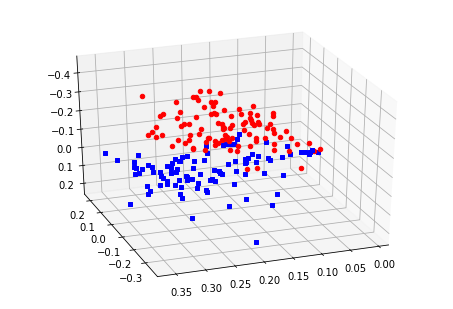

In [99]:
from mpl_toolkits.mplot3d import Axes3D

color = ['r','b', 'g']
marker = ['o', 's', '<']
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
for i in twopoints:
    f = i[1]
    t = i[0]
    ax.scatter3D(f[0], f[1], f[2], c = color[t], marker = marker[t])  
plt.show()

### filter to 3 cuisines

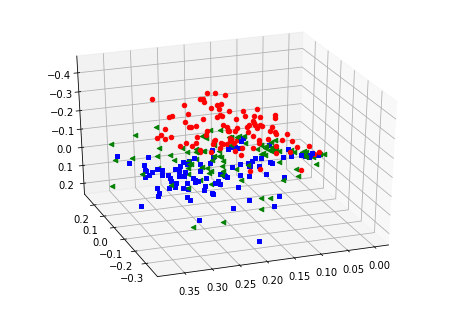

In [100]:
from mpl_toolkits.mplot3d import Axes3D

color = ['r','b', 'g']
marker = ['o', 's', '<']
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
for i in threepoints:
    f = i[1]
    t = i[0]
    ax.scatter3D(f[0], f[1], f[2], c = color[t], marker = marker[t])  
plt.show()

### filter to 4 cuisines

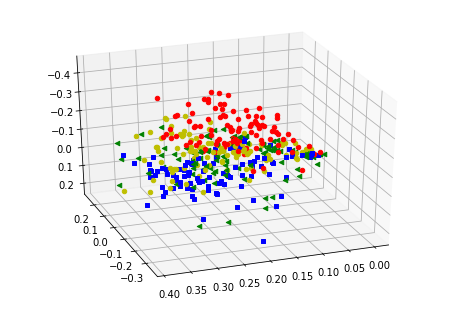

In [103]:
from mpl_toolkits.mplot3d import Axes3D

color = ['r','b', 'g','y']
marker = ['o', 's', '<','o']
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
for i in fourpoints:
    f = i[1]
    t = i[0]
    ax.scatter3D(f[0], f[1], f[2], c = color[t], marker = marker[t])  
plt.show()

In [ ]:
sc.stop()